In [8]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
import string
import spacy
import el_core_news_md
nlp = el_core_news_md.load()
from greek_stemmer import GreekStemmer
stemmer = GreekStemmer()
import re



def texts_retrieval(data_filename):
    df_texts = pd.read_csv(data_filename, index_col=None)
    return df_texts['text']



def sentences_retrieval(texts):
    documents = []
    for text in texts:
        documents += nltk.sent_tokenize(text)
    final_documents = []
    for j in range(len(documents)):   
        if re.search(r'[.!;][Α-Ω]', documents[j]) != None :
            sents = re.split(r'([.!;][Α-Ω])', documents[j])
            sentences = []
            for i in range(len(sents)):
                if i == 0:
                    sentences.append(sents[i])
                elif i%2 == 0:
                     sentences.append(sents[i-1][1] + sents[i])
            for sentence in sentences:
                if sentence != '':
                    final_documents.append(sentence)
        else:
            final_documents.append(documents[j])
        
    return final_documents



def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in (list(string.punctuation) + ['«', '»', '–', '“', '”', '\xa0']))
        if not all(pun):
            filtered_words.append(word)
    return filtered_words



def removing_accents(word):
    """
    Removes accents from a given word.
    
    Parameters
    ----------
    word : str
        the word from which we want to remove the accents

    Returns
    -------
    str
        the word without accents
    """
    return (word.replace('ά', 'α').replace('έ', 'ε').replace('ή', 'η').replace('ί', 'ι').replace('ό', 'ο').replace('ύ', 'υ')
            .replace('ώ', 'ω').replace('ϊ', 'ι').replace('ϋ', 'υ').replace('ΐ', 'ι').replace('ΰ', 'υ'))



def stemming(word):
    """
    Implements stemming for a given word.
    
    Parameters
    ----------
    word : str
        the word that is about to be stemmed

    Returns
    -------
    str
        the stem of the given word at uppercase letters
    """
    return stemmer.stem((removing_accents(word)).upper())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
texts = texts_retrieval('../data/votana_total_texts_annotated.csv')
documents = sentences_retrieval(texts)

In [10]:
len(documents)

41655

In [9]:
total_stop_words = (nlp.Defaults.stop_words).union(set(stopwords.words('greek')))
total_stop_words = total_stop_words.union({'ή', 'μόνον', '«', '»', '–', '“', '”', '\xa0', '‘', '•', '…', '●', '\uf0b7', '.◗'})
total_stop_words = list(total_stop_words) + list(string.punctuation)
#total_stop_words += [stemming(word) for word in total_stop_words]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = set(total_stop_words)
tokenized_stop_words = nltk.word_tokenize(' '.join(total_stop_words))

class Tokenizer(object):
    def __init__(self):
        nltk.download('punkt', quiet=True, raise_on_error=True)
        self.stemmer = GreekStemmer()
        
    def _stem(self, token):
        if (token in stop_words):
            return token
        return self.stemmer.stem((removing_accents(token)).upper())
        
    def __call__(self, line):
        tokens = nltk.word_tokenize(line)
        tokens = (self._stem(token) for token in tokens)
        tokens = thorough_filter(list(tokens))
        return tokens
    

vectorizer = TfidfVectorizer(max_df=0.7, min_df=6, stop_words=tokenized_stop_words, tokenizer=Tokenizer())
tf_idf_array = vectorizer.fit_transform(documents)

In [1]:
#print(vectorizer.stop_words_)

In [2]:
#print(vectorizer.get_feature_names())

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 41):
    km = KMeans(k, max_iter=3000)
    preds = km.fit_predict(tf_idf_array)
    silhouette_scores.append(silhouette_score(tf_idf_array, preds))

Maximum average silhouette score for k = 40


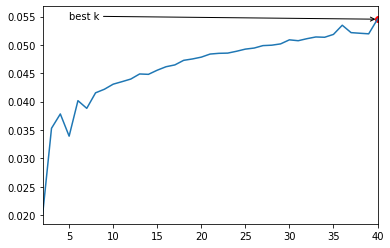

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(2, 41), silhouette_scores)
best_k = np.argmax(silhouette_scores) + 2 
plt.scatter(best_k, silhouette_scores[best_k-2], color='r') 
plt.xlim([2,40])
plt.annotate("best k", xy=(best_k, silhouette_scores[best_k-2]), xytext=(5, silhouette_scores[best_k-2]),arrowprops=dict(arrowstyle="->")) 
print('Maximum average silhouette score for k =', best_k)

In [16]:
km = KMeans(best_k)
km.fit(tf_idf_array)
print(km.labels_)

[ 2  4 14 ...  4 20  4]


In [5]:
from joblib import dump, load

In [17]:
dump(km, 'kmeans.joblib') 

['kmeans.joblib']

In [6]:
km = load('kmeans.joblib') 

In [22]:
#for i in range(len(km.labels_)):
#    if km.labels_[i]==10:
#        print('~')
#        print(documents[i])

In [20]:
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(best_k):
    out = "Cluster %d:" % i
    for ind in order_centroids[i, :10]:
        out += ' %s' % terms[ind]
    print(out)

Cluster 0: ΡΙΖ ΕΛΕΥΘΕΡ ΑΝΤΙΟΞΕΙΔΩΤ ΦΥΤ ΦΥΛΛ ΚΥΤΤΑΡ ΑΦΕΨΗΜ ΧΡΗΣΙΜΟΠΟΙ GINSENG ΘΕΡΑΠΕΥΤ
Cluster 1: ΠΕΡΙΕΧ ΟΥΣ ΟΞ ΣΥΣΤΑΤ ΔΡΑΣΤ ΠΟΥΡΝΑΡ ΦΩΤΕΙΝ ΦΛΑΒΟΝΟΕΙΔ ΑΝΤΙΟΞΕΙΔΩΤ ΧΗΜ
Cluster 2: ΘΕΡΑΠΕΙ ΧΡΗΣΙΜΟΠΟΙ ΧΡΗΣΙΜΟΠΟΙΕΙΤΑ ΑΣΘΕΝΕΙ ΠΡΟΒΛΗΜ ΙΑΤΡ ΑΠΟΤΕΛΕΣΜΑΤ ΦΥΣΙΚ ΧΡΗΣ ΒΟΤΑΝ
Cluster 3: ΑΡΘΡΟΥ ΕΚΤΥΠΩΣ ΠΕΡΙΓΡΑΦΟΜΕΝ ΠΡΟΕΚΥΨ ΙΣΟΡΡΟΠΗΜΕΝ ΠΛΑΙΣΙ ΑΛΛΑΓ ΥΓΙΕΙ ΑΡΧ ΠΑΡΑΠΑΝ
Cluster 4: ΧΡΗΣ ΚΑΛ ΜΕΓΑΛ OF ΦΑΡΜΑΚ ΧΡΟΝ ΜΕΛΕΤ ΚΑΝ ΠΟΝ ΓΕΥΣ
Cluster 5: ΙΔΙΟΤΗΤ ΘΕΡΑΠΕΥΤ ΒΟΤΑΝ ΑΝΤΙΦΛΕΓΜΟΝΩΔ ΧΡΗΣ ΦΥΤ ΑΝΤΙΟΞΕΙΔΩΤ ΦΑΡΜΑΚΕΥΤ ΕΥΕΡΓΕΤ ΠΕΡΙΣΣ
Cluster 6: ΕΠΙΠΕΔ ΧΟΛΗΣΤΕΡΟΛ ΑΙΜ ΣΑΚΧΑΡ ΜΕΙΩΣ ΜΕΙΩΝ ΔΙΑΒΗΤ ΧΟΛΗΣΤΕΡΙΝ ΓΛΥΚΟΖ ΥΨΗΛ
Cluster 7: ΗΜΕΡ ΠΙΝ ΦΟΡ ΦΛΙΤΖΑΝ ΣΟΥΡΩΝ 3 ΒΑΜΜ 1 2 1-2
Cluster 8: Δ ΒΟΤΑΝ ΜΠΟΡ ΙΔΙΟΤΗΤ ΥΓΕΙ ΣΥΝΤΑΓ ΦΥΣΙΚ ΠΕΡΙΣΣ ΔΙΑΤΡΟΦ ΔΕΝΤΡΟΛΙΒΑΝ
Cluster 9: ΣΥΣΤΗΜ ΑΝΟΣΟΠΟΙΗΤ ΝΕΥΡ ΠΕΠΤ ΕΝΙΣΧΥ ΑΝΑΠΝΕΥΣΤ ΛΕΙΤΟΥΡΓ ΕΝΙΣΧΥΣ ΟΡΓΑΝΙΣΜ ΚΕΝΤΡ
Cluster 10: ΑΠΟΚΛΕΙΣΤ ΔΙΚ ΑΝΑΦΕΡ ΧΡΗΣ ΔΕΚΕΜΒΡ ΙΑΝΟΥΑΡ ΜΑΡΤ ΣΕΠΤΕΜΒΡ ΟΚΤΩΒΡ ΝΟΕΜΒΡ
Cluster 11: ΣΠΟΡ ΦΥΤ ΧΡΗΣΙΜΟΠΟ ΦΥΛΛ ΠΟΛΛΑΠΛΑΣΙΑΖ ΚΑΡΠ ΠΕΡΙΕΧ ΧΡΗΣΙΜΟΠΟΙ ΡΙΖ ΑΦΕΨΗΜ
Cluster 12: ΝΕΡ ΛΕΠΤ ΦΛΙΤΖΑΝ 

* Cluster 0: 
    * ρίζες φυτών/βοτάνων (μέγεθος, χρώμα, κατά πόσο τρώγονται, θεραπευτικές ιδιότητες, χρήσεις, δόσεις)
    * ελέυθερες ρίζες (χημική ένωση) και αντιμετώπιση με αντιοξειδωτικά
    * πιο σπάνια ρίζες μαλλιών και ρίζα προβλήματος
    
* Cluster 1:
    * συστατικά/ουσίες είτε ονομαστικά (πιο συχνά) και πού περιέχονται είτε γενικά (πιο σπάνια) π.χ. χρήσιμες/βλαβερές ουσίες για οργανισμό
    
* Cluster 2:
    * θεραπείες/χρήσεις βοτάνων/φυτών
    * γενικότερες διαδικασίες θεραπειών
    
* Cluster 3:
    * συνήθης επίλογος άρθρων "Εκτύπωση άρθρουΟι συνταγές λειτουργούν στα πλαίσια μιας ισορροπημένης διατροφής και μιας γενικότερης αλλαγής του τρόπου ζωής, από τον οποίο προέκυψαν εξ αρχής τα παραπάνω περιγραφόμενα προβλήματα υγιείας" + πιθανώς μια φράση πιο πριν
    
* Cluster 4:
    * όχι τόσο ξεκάθαρο
    
* Cluster 5:
    * γενικά ιδιότητες βοτάνων/φυτών (θεραπευτικές, αντιοξειδωτικές, ευεργετικές κλπ. όχι συγκεκριμένα)
    
* Cluster 6:
    * χοληστερίνη, χοληστερόλη
    * σάκχαρο, διαβήτης
    
* Cluster 7:
    * δοδολογία την ημέρα (συνήθως για πόσιμα σε φλιτζάνια)
    
* Cluster 8:
    * στο τέλος των άρθρων προτάσεις για άλλα άρθρα (Δείτε και..)
    * πιο σπάνια δείτε σε άλλες περιπτώσεις μέσα στο κείμενο
    
* Cluster 9:
    * ενίσχυση κάποιου συστήματος του ανρθώπινου οργανισμού (γενικά) π.χ. πεπτικό, νευρικό, κυκλοφορικό κλπ.
    
* Cluster 10:
    * κλασική πρόταση για αποποίηση ευθύνης στο τέλος "Η χρήση όσων αναφέρονται είναι αποκλειστικά και μόνον δική σας ευθύνη" και μετά πιθανώς ημερομηνία άρθρου και ετικέτες αυτού